# BSTS Implementation Tutorial 1: Nowcasting

Hello fellow traveler! I can see by the look on your face that you want to know about how Baysean to implement  can be applied to time series analysis. I too am seeking those riches. The road ahead is dangerous, we should travel together. Will you join me? Great! Lets get going into the woods.

Before we begin, I assume that you know a basic understanding of **time series**: a stochastic process of state variables whose current state depends on its past, with some added random noise. Ahh time series, they are a mysterious and elusive technique used to predict the future. Together we may unravel these secrets. 

Whats that in the thicket? Its a time series of Sea Surface Temperature Off the coast of Gilbralter in the Atlantic Ocean. Lets use BSTS to model this time series, and make forecasts with this data.

Observe how it snakes up and down with the seasons. Bsts is for this seasonality, and models the underlying stationary time series.

Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  `Unnamed: 0.1` = col_integer(),
  `Unnamed: 0.1.1` = col_integer(),
  `Unnamed: 0.1.1.1` = col_integer(),
  `Unnamed: 0.1.1.1.1` = col_integer(),
  `Unnamed: 0.1.1.1.1.1` = col_double(),
  tempMean = col_double(),
  psalMean = col_double(),
  tempStd = col_double(),
  psalStd = col_double(),
  startDate = col_date(format = ""),
  endDate = col_date(format = ""),
  nProf = col_double()
)


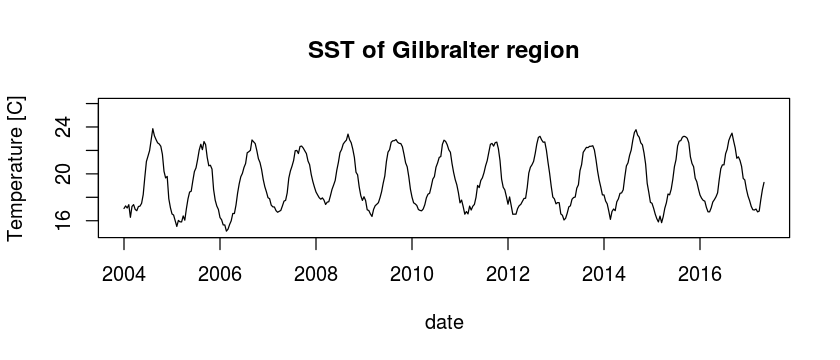

In [19]:
library(Boom)
library(zoo)
library(bsts)     # load the bsts package
library(readr)
library('latex2exp')
options( warn = -1 )
options(repr.plot.width=7, repr.plot.height=3)
gilbralter <- read_csv("data/gilbralter.csv")
gilT <- ts(gilbralter$tempMean, start=c(2004,1,13), end=c(2017, 11, 25), frequency=30)
plot(gilT, main='SST of Gilbralter region',
    xlab='date',
    ylab='Temperature [C]', 
    ylim=c(15, 26))

This time series is a 12 day aggregate. That makes 30 time indexes per year. 

We kick off bsts by desribing our state. The R code snippit here adds a local linear trend and a seasonal component with the time series object gilT.

These three lines of code are setting up the model as a linear sum.

$$
y_t = \mu_t + \tau_t + \epsilon_t
$$
y sub t is our output variable, where $\mu_t$ is a local linear component, $\tau_t$ is a seasonal component, and $\epsilon_t$ is a white noise process centered around zero with standard deviation $\sigma^2$. 

The model information stated here is stored in the state specification object ss

In [20]:
nseasons = 30 #A 12 day aggregate has 30 samples per period.
ss <- list()
ss <- AddLocalLinearTrend(ss, gilT)
ss <- AddSeasonal(ss, gilT, nseasons=nseasons)

The output variable's posterior distribution is estimated using the bsts() function. As input we use our time series object, state specification, and iteration number. 

In [21]:
model1 <- bsts(gilT,
               state.specification=ss,
               niter = 1000)

=-=-=-=-= Iteration 0 Tue Mar 27 20:31:42 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Mar 27 20:31:43 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Mar 27 20:31:44 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Mar 27 20:31:45 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Mar 27 20:31:47 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Mar 27 20:31:48 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Mar 27 20:31:49 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Mar 27 20:31:51 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Mar 27 20:31:52 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Mar 27 20:31:54 2018 =-=-=-=-=


What just happened? The output model1 is a list with the following keys.

In [31]:
names(model1)

[1] "sigma.obs"                  "sigma.trend.level"         
 [3] "sigma.trend.slope"          "sigma.seasonal.30"         
 [5] "final.state"                "state.contributions"       
 [7] "one.step.prediction.errors" "log.likelihood"            
 [9] "has.regression"             "state.specification"       
[11] "prior"                      "timestamp.info"            
[13] "model.options"              "family"                    
[15] "niter"                      "original.series"

We assume our model converges after 1000 iterations. We check if our assumption is valid by plotting our Expected conditional posterior with the data, shown on this chart. The blue bubbles are data, and the black line is our model. Looks alright to me.

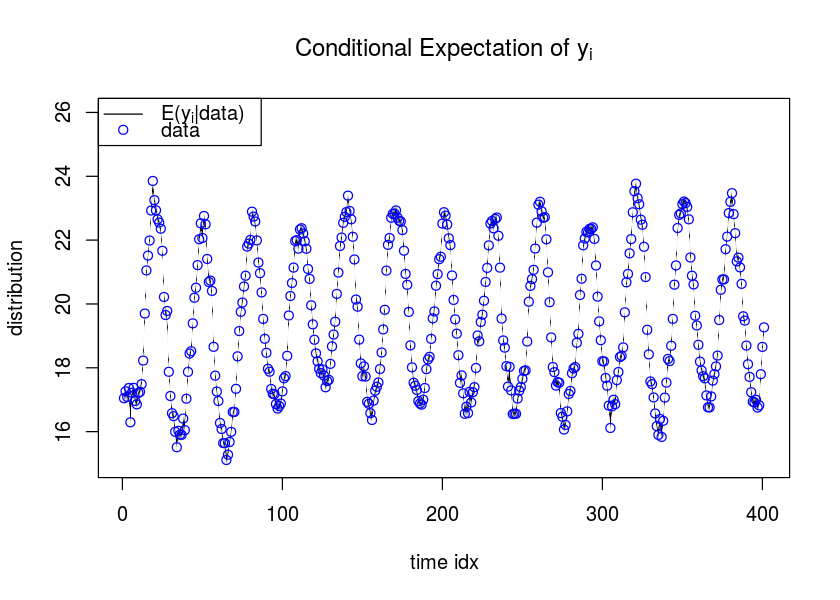

In [22]:
options(repr.plot.width=7, repr.plot.height=5)
plot(model1,
    main=TeX('Conditional Expectation of $y_i$'),
    xlab='time idx',
    ylab='distribution', 
    ylim=c(15, 26))
par(xpd=TRUE)
legend("topleft", legend=c(TeX('$E(y_i|data)$'), "data"),
col=c("black", "blue"), lty=c(1,NA), pch=c(NA, 1), cex=1)

Adding a 'components' tag to the plot displays trend and seasonal data. We can see that our bsts model captures the seasonality and trend fairly well.

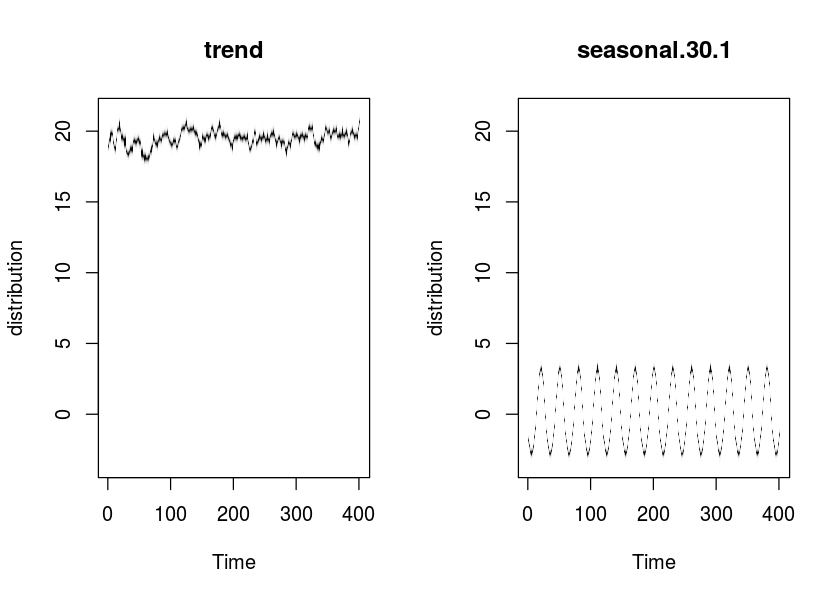

In [23]:
plot(model1, "components")

From here we can make forcasts. The chart here predicts 12 time steps in the future (144 days). The predictive posterior is in black in white. See how the green dotted lines spread apart as we predict further in the future? This typical for non-stationary time series such as ours. I Wonder if there is anything we can do to make this interval more narrow. Can we improve the model's predicitive precision? 

In our next video, we will look into refining our model by including linear regression terms. I will meet you there.

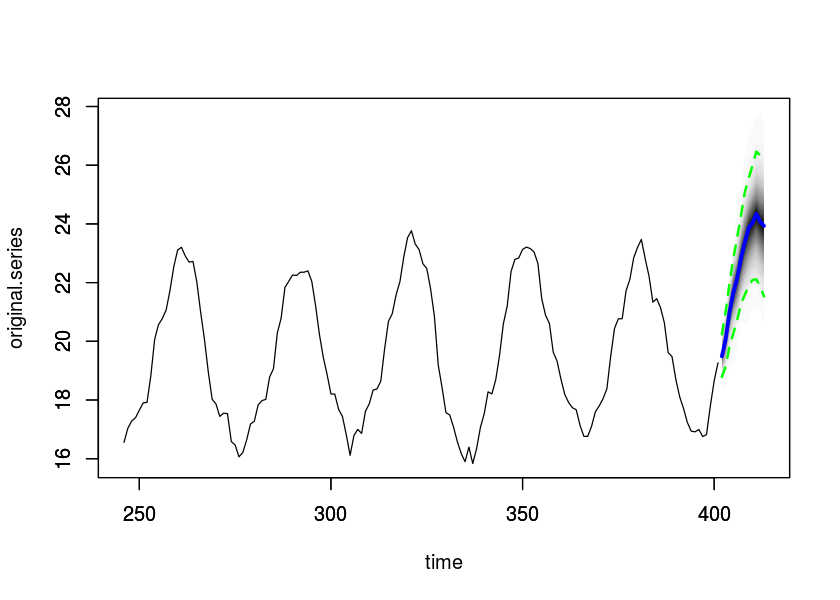

In [26]:
pred1 <- predict(model1, horizon = 12)
plot(pred1, plot.original = 156)

In [27]:
pred1

$mean
 [1] 19.51108 20.05829 20.96153 21.63463 22.11079 22.80036 23.33322 23.75728
 [9] 24.03174 24.27446 24.05665 23.89964

$median
 [1] 19.48890 20.06787 20.99277 21.66800 22.14139 22.83692 23.36254 23.86468
 [9] 24.03659 24.34252 24.07325 23.93484

$interval
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
2.5%  18.78548 19.13846 19.82335 20.26399 20.72945 21.27402 21.58715 21.88205
97.5% 20.23758 21.01213 21.97355 22.82539 23.53527 24.29404 25.08811 25.54974
          [,9]    [,10]    [,11]    [,12]
2.5%  22.08896 22.11385 21.87141 21.52971
97.5% 25.99245 26.46108 26.33941 26.12476

$distribution
           [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
  [1,] 19.15353 19.42034 19.93149 20.88658 20.97196 21.53593 22.21689 22.47304
  [2,] 19.81873 20.18718 21.34115 22.02488 22.61275 22.88695 23.40890 23.16155
  [3,] 19.33366 20.18810 21.07959 21.14452 21.71429 22.80701 23.45340 24.31078
  [4,] 18.86181 19.53287 19.80441 20.19538 21.0

### Your quest, should you choose to accept...

What a method! But how does it work? Glory and reward await those who are brave enough to navigate the trials and tribulations involved in learning bsts. Come stalwart adventurer! let us explore this dungeon of mysterious treasures. In the following tutorials, we will battle untold horrors and demons together, who guard the secrects of bsts. With this power we will be able to

* Modeling non-gaussian noise

* Apply Spike and slab priors (a flatish prior with a large spike at zero. This prior is saying that the regression components are most likely zero, but if not are relatively flat.

* Apply several type of Monte Carlo Markov Chains

* Forcast long term trends

Some theory reading is available here [here](http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf)

Another tutorial by Steven L. Scott, the Author of BSTS is [here](http://www.unofficialgoogledatascience.com/2017/07/fitting-bayesian-structural-time-series.html)

Code used to create this notebook is located [here](https://github.com/asbates/bayes-time-series)

[bsts documentation](https://cran.r-project.org/web/packages/bsts/bsts.pdf)